### Apprentissage profond - TD n°2
__________
Architectures DNN classiques appliquées à la classification de chiffres avec MNIST

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# we use GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Données et problème

On réutilise le dataset MNIST déjà téléchargé au TD précédent. Cette fois-ci, on va charger les données avec le module `Dataloader` de pytorch.

In [3]:
from torchvision import datasets, transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])

my_data_path = './data'
train_set = datasets.MNIST( my_data_path, train=True, transform=trans, download=True )
test_set = datasets.MNIST( my_data_path, train=False, transform=trans, download=True )


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:19<00:00, 516490.87it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 389124.72it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2082263.78it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 527321.08it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



Consulter la [documentation PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) à propos des modules `Dataset` et `Dataloader`.

NB : en pratique, on pourra définir [son propre dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) pour un cas d'utilisation donné.

In [5]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=True)


print('total training batch number: {}'.format(len(train_loader)))
print('total testing batch number: {}'.format(len(test_loader)))


total training batch number: 600
total testing batch number: 100


Visualisation des images en utilisant le chargement des données avec `Dataloader`.

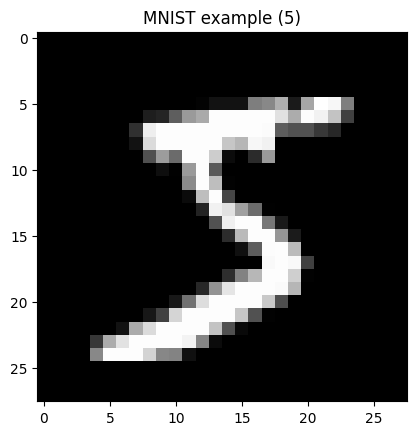

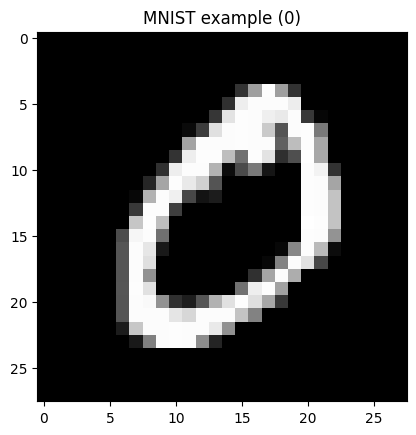

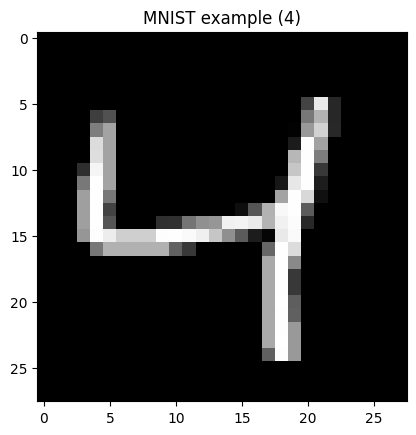

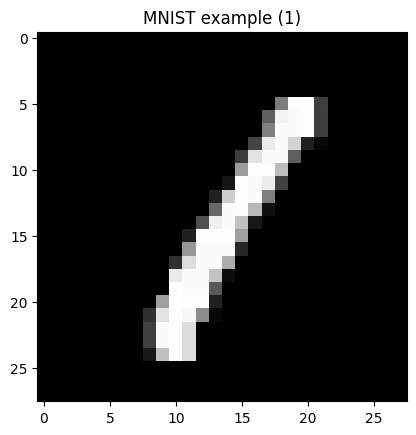

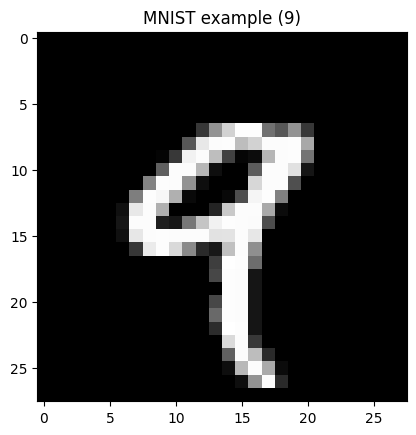

In [8]:
# display some images
# for an alternative see https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
def imshow(tensor, title=None):
    img = tensor.cpu().clone()
    img = img.squeeze()
    plt.imshow(img, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.5)

plt.figure()
for ii in range(5):
    imshow(train_set.data[ii] , title='MNIST example ({})'.format(train_set.targets[ii]) )
plt.close()

### Modélisation MLP

On commence par définir les tailles d'entrée et de sortie du réseau.

In [9]:
# définition des tailles d'entrée et de sortie
DATA_SIZE = 784 # 28*28
NUM_CLASSES = 10

__Régression softmax__

Implémentation d'une classe `RegSoftNet` pour apprendre un modèle de régression softmax (généralisation à >  2 classesde la régression logistique).

Ici on utilise simplement 1 couche cachée.

In [ ]:
class RegSoftNet(nn.Module):
    def __init__(self):
        super(RegSoftNet, self).__init__()
        self.fc = nn.Linear(DATA_SIZE, NUM_CLASSES)
    def forward(self, x):
        x = x.view(-1, DATA_SIZE) # passer de 28*28 à  (784,)
        x = x.relu(self.fc(x))
        return x

In [ ]:
model = RegSoftNet()
model.to(device) # pour faire passer le modèle sur GPU / CPU

# optimization hyperparameters
optimizer = TODO
loss_fn = TODO

NB : Utilisation de model.train(), model.eval(), et with torch.no_grad()
* model.train() active les couches de type "dropout" ou "batchnorm". __Par défaut, tous les modules sont initialisés avec `train = True`__.
* model.eval() désactive la mise à jour des couches de type "dropout" ou "batchnorm".
* with torch.no_grad() économise de la mémoire et du temps de calcul au moment de l'inférence, dans la mesure où cela désactive la stockage des valeurs intermédiaires dans le graphe de calcul. Conserver en mémoire ces valeurs intermédiaires est utile pour effectuer la rétropropagation, mais inutile à l'inférence.

In [ ]:
# Entrainement et évaluation

for epoch in range(10):
    # training
    model.train() 
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.to(device), target.to(device)
        out = model(x)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if batch_idx %100 ==0:
            print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*len(x),
                    len(train_loader.dataset),loss.item()))
    # testing
    model.eval()
    correct = 0
    with torch.no_grad():
        confusion = torch.zeros(NUM_CLASSES,NUM_CLASSES)
        for batch_idx, (x, target) in enumerate(test_loader):
            x, target = x.to(device), target.to(device)
            out = model(x)
            loss = loss_fn(out, target)
            # _, prediction = torch.max(out.data, 1)
            prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            # since 'prediction' and 'target' may be on the GPU memory
            # thus (i,j) are on the GPU as well. They must be transfered
            # to the CPU, where 'confusion' has been allocated
            for i,j in zip(prediction,target):
                confusion[i.to("cpu"),j.to("cpu")] += 1
    taux_classif = 100. * correct / len(test_loader.dataset)
    print('Test Accuracy: {}/{} (tx {:.2f}%, err {:.2f}%)\n'.format(correct,
     len(test_loader.dataset), taux_classif, 100.-taux_classif))
    torch.set_printoptions(sci_mode=False)
    print(confusion)


__Perceptron multi-couche__

On utilise ici 2 couches cachées.

In [ ]:
NUM_HIDDEN_1 = 256
NUM_HIDDEN_2 = 256

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = TODO
        self.fc2 = TODO
        self.fc3 = TODO
    def forward(self, x):
        x = x.view(-1, DATA_SIZE) # reshape the tensor 
        x = TODO
        x = TODO
        x = TODO
        return x

In [ ]:
model = MLPNet()
model.to(device) # pour faire passer le modèle sur GPU / CPU

# redéfinir l'optimiseur ! 
optimizer = TODO
loss_fn = TODO

A nouveau, on entraine le modèle et on affiche au fur et à mesure des "epochs" la matrice de confusion sur les données d'évaluation. 

In [ ]:
# Entrainement et évaluation

for epoch in range(10):
    # training
    model.train() 
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.to(device), target.to(device)
        out = model(x)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if batch_idx %100 ==0:
            print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*len(x),
                    len(train_loader.dataset),loss.item()))
    # testing
    model.eval()
    correct = 0
    with torch.no_grad():
        confusion = torch.zeros(NUM_CLASSES,NUM_CLASSES)
        for batch_idx, (x, target) in enumerate(test_loader):
            x, target = x.to(device), target.to(device)
            out = model(x)
            loss = loss_fn(out, target)
            # _, prediction = torch.max(out.data, 1)
            prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            # since 'prediction' and 'target' may be on the GPU memory
            # thus (i,j) are on the GPU as well. They must be transfered
            # to the CPU, where 'confusion' has been allocated
            for i,j in zip(prediction,target):
                confusion[i.to("cpu"),j.to("cpu")] += 1
    taux_classif = 100. * correct / len(test_loader.dataset)
    print('Test Accuracy: {}/{} (tx {:.2f}%, err {:.2f}%)\n'.format(correct,
     len(test_loader.dataset), taux_classif, 100.-taux_classif))
    torch.set_printoptions(sci_mode=False)
    print(confusion)


### Modélisation CNN

Consulter la [documentation PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#conv2d) de la class `Conv2D`.

> class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

Taille d'entrée : (N,Cin,H,W) x (N,Cin​,H,W) 

Taille de sortie : (N,Cout,Hout,Wout) x (N,Cout​,Hout​,Wout​)

avec : 
* N : batch size
* Cin et Cout : nombre de filtres respectivement en entrée et sortie (channels)
* H et W : height and width des filtres en entrée
* Hout et Wout : height and width des filtres en sortie

TODO : calcul des dimensions de sortie des couches de convolution et de pooling.

In [ ]:
# Implémentation d'un CNN avec deux couches convolutives
# v1 sans Dropout
# v2 ajouter une couche de Dropout après les 2 couches de conv

NUM_CONV_1= TODO
NUM_CONV_2= TODO
NUM_FC= TODO

class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        self.conv_1 = nn.Conv2d(TODO,TODO,5,1) # kernel_size = 5
        self.conv_2 = nn.Conv2d(TODO,TODO,5,1) # kernel_size = 5
        self.fc_1 = nn.Linear(TODO_H, TODO)
        self.fc_2 = nn.Linear(TODO,NUM_CLASSES)
    def forward(self,x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,TODO_H)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x
        # en utilisant loss = F.nll_loss(output, target) on peut faire
        # return F.log_softmax(x, dim=1)


NB : de manière équivalente, en utilisant `loss = F.nll_loss(output, target)` au lieu de `loss = CrossEntropyLoss()` on peut écrire :

> return F.log_softmax(x, dim=1)

In [ ]:
model = CNNNet()
model.to(device) # pour faire passer le modèle sur GPU / CPU

# optimization hyperparameters
optimizer = TODO
loss_fn = TODO

In [ ]:
# Entrainement et évaluation

for epoch in range(10):
    # training
    model.train() 
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.to(device), target.to(device)
        out = model(x)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if batch_idx %100 ==0:
            print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*len(x),
                    len(train_loader.dataset),loss.item()))
    # testing
    model.eval()
    correct = 0
    with torch.no_grad():
        confusion = torch.zeros(NUM_CLASSES,NUM_CLASSES)
        for batch_idx, (x, target) in enumerate(test_loader):
            x, target = x.to(device), target.to(device)
            out = model(x)
            loss = loss_fn(out, target)
            # _, prediction = torch.max(out.data, 1)
            prediction = out.argmax(dim=1, keepdim=True) # index of the max log-probability
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            # since 'prediction' and 'target' may be on the GPU memory
            # thus (i,j) are on the GPU as well. They must be transfered
            # to the CPU, where 'confusion' has been allocated
            for i,j in zip(prediction,target):
                confusion[i.to("cpu"),j.to("cpu")] += 1
    taux_classif = 100. * correct / len(test_loader.dataset)
    print('Test Accuracy: {}/{} (tx {:.2f}%, err {:.2f}%)\n'.format(correct,
     len(test_loader.dataset), taux_classif, 100.-taux_classif))
    torch.set_printoptions(sci_mode=False)
    print(confusion)

__Calcul de la taille d'un modèle__

In [ ]:
# parametres + buffers (e.g. batch norm)

def get_model_size(model):
    """ 
    in megabites --> divide by 1024**2
    """
    param_size = 0
    for p in model.parameters() :
        param_size += TODO

    buffer_size = 0
    for b in model.buffers() :
        buffer_size += TODO

    return (param_size + buffer_size) / 1024**2


__Sauvegarde des poids du modèle__

Il y a deux manières de sauvegarder un modèle suivant si on utilise `state_dict()` ou pas. Comparer avec la [documentation PyTorch](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

> A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor. Note that only layers with learnable parameters (convolutional layers, linear layers, etc.) and registered buffers (batchnorm’s running_mean) have entries in the model’s state_dict. Optimizer objects (torch.optim) also have a state_dict, which contains information about the optimizer’s state, as well as the hyperparameters used.

In [ ]:
# sauvegarde
print(model)
torch.save(model, 'my_cnn.pth')

# chargement
model1 = torch.load('./my_cnn.pth')
print(model1)

In [ ]:
# Utilisation de state_dict : on accède aux paramètres du modèle

# sauvegarde
print(model.state_dict().keys())
torch.save(model.state_dict(), 'my_cnn_params.pth')

# chargement : il faut définir le modèle puis charger les poids
model2 = CNNNet()
model2.load_state_dict(torch.load('my_cnn_params.pth'))
print(model2)

__Visualisation des feature maps (cartes d'activation)__

Se référer au script `visualize_cnn_features.py`. Il utilise les poids du CNN, que l'on vient de sauvegarder. 

Autres références pour visualiser les cartes d'activation d'un CNN : [un réseau plus profond](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/)  et [une autre méthode de visualisation](https://blbadger.github.io/feature-visualization.html) (en optimisant l'entrée de manière à maximiser la réponse d'un filtre donné).

### Modèles LSTM et Bi-LSTM

Se référer à la [documentation PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) pour le module `LSTM`.

__LSTM__

In [ ]:
# Hyper-parameters
sequence_length = 28 # on voit une image comme une chaine de 28 mots
input_size = 28 # chaque mot fait 28 caractères
hidden_size = 128
num_layers = 1
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.001

In [ ]:
# define LSTM model
class LSTMNet(nn.Module):
    def __init__(self,in_size,hidden_size, nb_layer, nb_classes):
        super(LSTMNet,self).__init__()
        self.hidden_size = hidden_size
        self.nb_layer = nb_layer
        self.nb_classes = nb_classes
        self.lstm = nn.LSTM(in_size,hidden_size,nb_layer,batch_first=True)
        self.fc = nn.Linear(hidden_size,nb_classes)

    def forward(self,x):
        # initial states
        h0 = torch.zeros(self.nb_layer, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.nb_layer, x.size(0), self.hidden_size).to(device)

        out,_ = self.lstm(x, (h0,c0))
        out = self.fc(out[:,-1,:])
        return out

In [ ]:
model = LSTMNet(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_fn = nn.CrossEntropyLoss()


In [ ]:
import time 

# training
total_step = len(train_loader)
start = time.time()
for epoch in range(num_epochs):
    for i,(img,lab) in enumerate(train_loader):
        img = img.reshape(-1,sequence_length,input_size).to(device)
        lab = lab.to(device)

        outputs = model(img)
        loss = loss_fn(outputs,lab)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} ({:.2f} s)'
            .format(epoch+1, num_epochs, i+1, total_step,
            loss.item(), time.time()-start))

# test
with torch.no_grad():
    correct = 0
    total = 0
    for img, lab in test_loader:
        img = img.reshape(-1,sequence_length,input_size).to(device)
        lab = lab.to(device)
        outputs = model(img)
        _, pred = torch.max(outputs.data,1)
        total += lab.size(0)
        correct += (pred == lab).sum().item()

    print('Test Accuracy: {}%'.format(100. * correct / total) )



__BiLSTM__

On passe l'option "bidirectional" à "True" dans nn.LSTM, et on adapte les dimensions des tenseurs dans le réseau.

In [ ]:
learning_rate = 0.0005 # for BiLSTM

In [ ]:
# define BiLSTM model
class BiLSTMNet(nn.Module):
    def __init__(self,in_size,hidden_size, nb_layer, nb_classes):
        super(BiLSTMNet,self).__init__()
        self.hidden_size = hidden_size
        self.nb_layer = nb_layer
        self.nb_classes = nb_classes
        self.lstm = nn.LSTM(in_size,hidden_size,nb_layer,batch_first=True,bidirectional=True)
        self.fc = nn.Linear(hidden_size*2,nb_classes)  # 2 for bidirection

    def forward(self,x):
        # initial states
        h0 = torch.zeros(self.nb_layer*2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.nb_layer*2, x.size(0), self.hidden_size).to(device)

        out,_ = self.lstm(x, (h0,c0))
        out = self.fc(out[:,-1,:])
        return out

In [ ]:
model = BiLSTMNet(input_size, hidden_size, num_layers, num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# training
total_step = len(train_loader)
start = time.time()
for epoch in range(num_epochs):
    for i,(img,lab) in enumerate(train_loader):
        img = img.reshape(-1,sequence_length,input_size).to(device)
        lab = lab.to(device)

        outputs = model(img)
        loss = loss_fn(outputs,lab)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} ({:.2f} s)'
            .format(epoch+1, num_epochs, i+1, total_step,
            loss.item(), time.time()-start))

# test
with torch.no_grad():
    correct = 0
    total = 0
    for img, lab in test_loader:
        img = img.reshape(-1,sequence_length,input_size).to(device)
        lab = lab.to(device)
        outputs = model(img)
        _, pred = torch.max(outputs.data,1)
        total += lab.size(0)
        correct += (pred == lab).sum().item()

    print('Test Accuracy: {}%'.format(100. * correct / total) )